In [1]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u 
from astropy.table import Table
from itertools import groupby
import itertools
import numpy as np
from matplotlib.patches import Ellipse


In [2]:
# read the catalogues
GLEAM=Table.read('GLEAM_EGC_v2_fit_poly_G23_D.fits',format='fits')
TGSS=Table.read('TGSS_DR1_7sig_G23_D.fits',format='fits')
NVSS=Table.read('NVSS_G23_D.fits',format='fits')

# read Jonathan catalogue (from email 2 July 2019)
GAMA_conso=Table.read('GLASS_G23_D_CONSOLIDATED_V1.dat',format='ascii')
G5G=Table.read('GLASS_5GHz_components.dat',format='ascii')
G9G=Table.read('GLASS_9GHz_components.dat',format='ascii')

# create coord arrays for crossmatch
GLEAM_coord=SkyCoord(GLEAM['RAJ2000'],GLEAM['DEJ2000'])
TGSS_coord=SkyCoord(TGSS['RA'],TGSS['DEC'])
NVSS_coord=SkyCoord(NVSS['RAJ2000'],NVSS['DEJ2000'],unit=(u.hourangle,u.degree)) # small trick as in sexa form
G5G_coord=SkyCoord(G5G['5GHz_ra'],G5G['5GHz_dec'],unit=(u.degree,u.degree))
G9G_coord=SkyCoord(G9G['9GHz_ra'],G9G['9GHz_dec'],unit=(u.degree,u.degree))


/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


NVSS PA is nan!


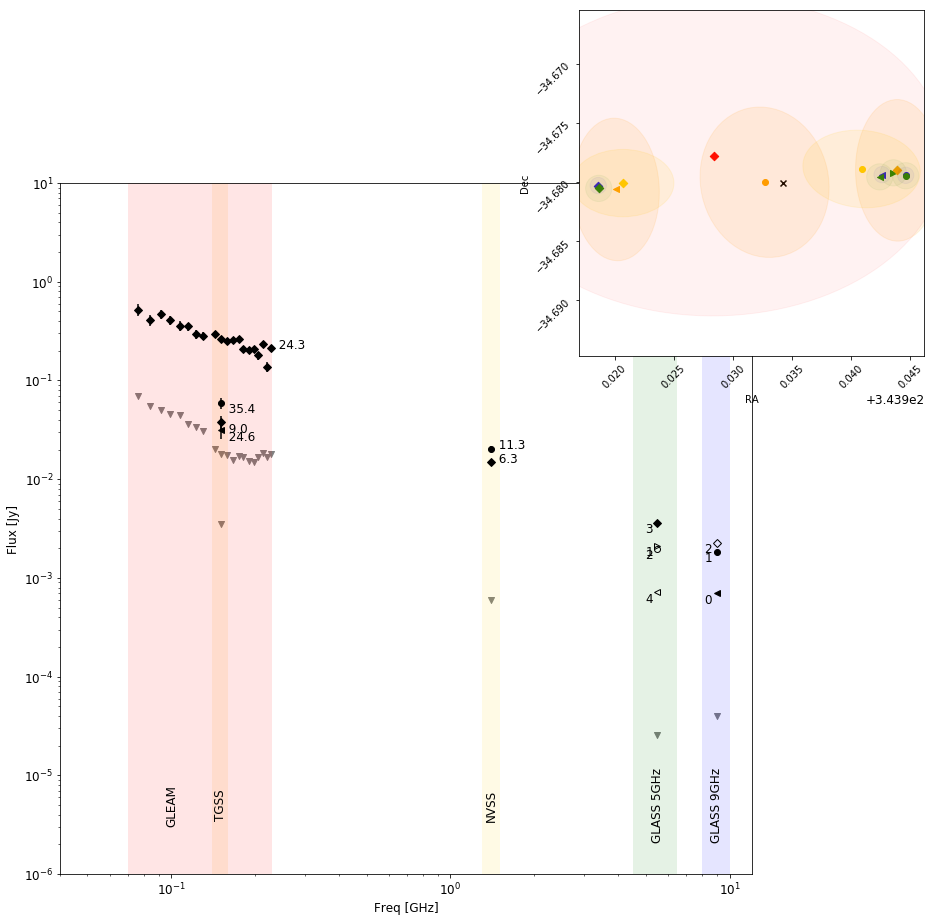

In [169]:
# main figure
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111,position=[0,0,0.8,0.8])

# inset
#inset_axt = fig.add_axes([0.75, 0.8, 0.23, 0.18],aspect='equal')
inset_axt = fig.add_axes([0.6, 0.6, 0.4, 0.4],aspect='equal',adjustable='datalim')

matplotlib.rc('font', **{'size':12})
GLEAM_namecol=[GLEAM.colnames[30+i] for i in np.arange(20)*14]
GLEAM_freq=[np.float(i.split('_')[-1]) for i in GLEAM_namecol]

G9G_color='blue'
G5G_color='green'
NVSS_color='gold'
TGSS_color='orange'
GLEAM_color='red'
sep_matching_NVSS=40.*u.arcsec
sep_matching_TGSS=50.*u.arcsec
sep_matching_GLEAM=80.*u.arcsec
marker = ['D', 'o', '<', '>', 's', '8', 'p', '.']

limit_G9G=np.median(G9G['9GHz_local_rms'])
limit_G5G=np.median(G5G['5GHz_local_rms'])
limit_NVSS=np.median(NVSS['e_S1.4'])*1e-3
limit_TGSS=np.median(TGSS['RMS_noise'])*1e-3
limit_GLEAM=[np.median(GLEAM["local_rms_{:03d}".format(np.int(i))]) for i in GLEAM_freq]

# TODO
#  => upper limits for the different surveys
#  => errrobars on the points (done for G9G, G5G, NVSS, TGSS, GLEAM) - beware no empty symbol for NVSS/TGSS
#  => small inset with a sketch of the source (done)
#  => some warning if (i) no counterpart


# Source to plot

#i=439 # single all frequency
#i=1820 # multi component
i=1700 # ross source
#i=475  # nick source
# find the matching flux in the component catalogue

# a cross to mark the host position
inset_axt.scatter(GAMA_conso[i]['HOST_RA'],GAMA_conso[i]['HOST_DEC'],color='k',marker='x')

# 9GHz 
idx_G9G=np.where(GAMA_conso['G9_IAUID'][i]==G9G['GLASS_IAUID'])[0]
for j,idx in enumerate(idx_G9G):
    # SED
    ax.text(9.0,G9G['9GHz_int_flux'][idx_G9G][j],"{} ".format(G9G['ComponentNum'][idx_G9G][j]),va='top',ha='right')
    if G9G['9GHz_err_int_flux'][idx]<-90.:
        ax.plot([9.0],G9G['9GHz_int_flux'][idx],marker=marker[j],c='k',ls='None',markerfacecolor='None')
    else :
        ax.errorbar([9.0],G9G['9GHz_int_flux'][idx],G9G['9GHz_err_int_flux'][idx],marker=marker[j],c='k',ls='None')
    # sketch
    inset_axt.scatter(G9G['9GHz_ra'][idx],G9G['9GHz_dec'][idx],color=G9G_color,marker=marker[j])
    inset_axt.add_artist(Ellipse((G9G['9GHz_ra'][idx],G9G['9GHz_dec'][idx]),
                                 5./3600.,5./3600.,0.,
                                color=G9G_color,alpha=0.05))

# 5GHz    
idx_G5G=np.where(GAMA_conso['G5_IAUID'][i]==G5G['GLASS_IAUID'])[0]
for j,idx in enumerate(idx_G5G):
    # SED
    ax.text(5.5,G5G['5GHz_int_flux'][idx_G5G][j],"{} ".format(G5G['ComponentNum'][idx_G5G][j]),va='top',ha='right')
    if G5G['5GHz_err_int_flux'][idx]<-90.:
        ax.plot([5.5],G5G['5GHz_int_flux'][idx],marker=marker[j],c='k',ls='None',markerfacecolor='None')
    else :
        ax.errorbar([5.5],G5G['5GHz_int_flux'][idx],G5G['5GHz_err_int_flux'][idx],marker=marker[j],c='k',ls='None')
    # sketch
    inset_axt.scatter(G5G['5GHz_ra'][idx],G5G['5GHz_dec'][idx],color=G5G_color,marker=marker[j])
    inset_axt.add_artist(Ellipse((G5G['5GHz_ra'][idx],G5G['5GHz_dec'][idx]),
                                 8./3600.,8./3600.,0.,
                                color=G5G_color,alpha=0.05))

# crossmatch with NVSS
# matching 5GHz components with NVSS
single_G5G_coord=SkyCoord(G5G['5GHz_ra'][idx_G5G],G5G['5GHz_dec'][idx_G5G],unit=(u.degree,u.degree))
idx_G5G_NVSS, idx_NVSS_G5G, d2d_G5N, d3d_G5N = single_G5G_coord.search_around_sky(NVSS_coord, sep_matching_NVSS)
idx_G5G_NVSS=[k for k,g in groupby(idx_G5G_NVSS)]
for j,idx in enumerate(idx_G5G_NVSS):
    # SED
    ax.errorbar([1.4],NVSS['S1.4'][idx]*1e-3,NVSS['e_S1.4'][idx]*1e-3,marker=marker[j],c='k',ls='None')
    ax.text(1.4,NVSS['S1.4'][idx]*1e-3,"  {:.1f}".format(d2d_G5N.arcsec[j]))
    # sketch
    inset_axt.scatter(NVSS['RA'][idx],NVSS['DEC'][idx],color=NVSS_color,marker=marker[j])
    if np.isfinite(NVSS['PA'][idx])==False:
        tmp_pa=0.
        print("NVSS PA is nan!")
    else:
        tmp_pa=NVSS['PA'][idx]+90.
    inset_axt.add_artist(Ellipse((NVSS['RA'][idx],NVSS['DEC'][idx]),
                                 NVSS['MajAxis'][idx]/3600.,NVSS['MinAxis'][idx]/3600.,tmp_pa,
                                color=NVSS_color,alpha=0.1))

# crossmatch with TGSS
# matching NVSS components with TGSS
single_NVSS_coord=SkyCoord(NVSS['RAJ2000'][idx_G5G_NVSS],NVSS['DEJ2000'][idx_G5G_NVSS],unit=(u.hourangle,u.degree))       
idx_TGSS_NVSS, idx_NVSS_TGSS, d2d_TN, d3d_TN = single_NVSS_coord.search_around_sky(TGSS_coord, sep_matching_TGSS)
idx_TGSS_NVSS=[k for k,g in groupby(idx_TGSS_NVSS)]
for j,idx in enumerate(idx_TGSS_NVSS):
    # SED
    ax.text(0.15,TGSS['Total_flux'][idx_TGSS_NVSS][j]*1e-3,"  {:.1f}".format(d2d_TN.arcsec[j]),va='top')
    ax.errorbar([0.15],TGSS['Total_flux'][idx]*1e-3,TGSS['E_Total_flux'][idx]*1e-3,marker=marker[j],c='k',ls='None')
    # sketch
    inset_axt.scatter(TGSS['RA'][idx],TGSS['DEC'][idx],color=TGSS_color,marker=marker[j])
    inset_axt.add_artist(Ellipse((TGSS['RA'][idx],TGSS['DEC'][idx]),
                                 TGSS['Maj'][idx]/3600.,TGSS['Min'][idx]/3600.,TGSS['PA'][idx]+90.,
                                color=TGSS_color,alpha=0.1))

# crossmatch with GLEAM
# matching NVSS components with GLEAM
# coordinates already created for the TGSS crossmatch
idx_GLEAM_NVSS, idx_GLEAM_TGSS, d2d_GN, d3d_GN = single_NVSS_coord.search_around_sky(GLEAM_coord, sep_matching_GLEAM)
idx_GLEAM_NVSS=[k for k,g in groupby(idx_GLEAM_NVSS)]
inset_axt.scatter(GLEAM['RAJ2000'][idx_GLEAM_NVSS],GLEAM['DEJ2000'][idx_GLEAM_NVSS],color=GLEAM_color,marker='.')
for j,idx in enumerate(idx_GLEAM_NVSS):
    # sketch
    inset_axt.scatter(GLEAM['RAJ2000'][idx],GLEAM['DEJ2000'][idx],color=GLEAM_color,marker=marker[j])
    inset_axt.add_artist(Ellipse((GLEAM['RAJ2000'][idx],GLEAM['DEJ2000'][idx]),
                                 GLEAM['a_227'][idx]/3600.,GLEAM['b_227'][idx]/3600.,GLEAM['pa_227'][idx]+90.,
                                color=GLEAM_color,alpha=0.05))
    # SED
    ax.text(0.227,GLEAM['int_flux_227'][idx],"  {:.1f}".format(d2d_GN.arcsec[j]))
    for n,nu in enumerate(GLEAM_freq):
        if GLEAM[GLEAM_namecol[n]][idx]<0.:
            ax.plot(nu*1e-3,GLEAM[GLEAM_namecol[n]][idx],marker=marker[j],c='k',ls='None',markerfacecolor='None')        
        else:
            ax.errorbar(nu*1e-3,GLEAM[GLEAM_namecol[n]][idx],GLEAM["err_{}".format(GLEAM_namecol[n])][idx],marker=marker[j],c='k',ls='None')
    

# plot the limit of surveys
ax.scatter([9.0,5.5,1.4,0.15],[limit_G9G,limit_G5G,limit_NVSS,limit_TGSS],marker='v',c='grey')
ax.scatter(np.array(GLEAM_freq)*1e-3,limit_GLEAM,marker='v',c='grey')

# some of the cosmetics
ax.set_xlabel('Freq [GHz]')
ax.set_ylabel('Flux [Jy]')
ax.set_xlim(0.04,12.);ax.set_ylim(1e-6,10.)
ax.set_xscale('log');ax.set_yscale('log')
ax.fill_between([8.,10.],ax.get_ylim()[0],ax.get_ylim()[1],facecolor=G9G_color, alpha=0.1)
ax.fill_between([4.5,6.5],ax.get_ylim()[0],ax.get_ylim()[1],facecolor=G5G_color, alpha=0.1)
ax.fill_between([1.3,1.5],ax.get_ylim()[0],ax.get_ylim()[1],facecolor=NVSS_color, alpha=0.1)
ax.fill_between([0.14,0.16],ax.get_ylim()[0],ax.get_ylim()[1],facecolor=TGSS_color, alpha=0.1)
ax.fill_between([0.07,0.23],ax.get_ylim()[0],ax.get_ylim()[1],facecolor=GLEAM_color, alpha=0.1)

ax.text(5.5, ax.get_ylim()[0]*5., 'GLASS 5GHz', ha='center',va='center',rotation='vertical')
ax.text(9.0, ax.get_ylim()[0]*5., 'GLASS 9GHz', ha='center',va='center',rotation='vertical')
ax.text(1.4, ax.get_ylim()[0]*5., 'NVSS', ha='center',va='center',rotation='vertical')
ax.text(0.100, ax.get_ylim()[0]*5., 'GLEAM', ha='center',va='center',rotation='vertical')
ax.text(0.150, ax.get_ylim()[0]*5., 'TGSS', ha='center',va='center',rotation='vertical')

inset_axt.set_xlabel('RA',fontsize=10)
inset_axt.set_ylabel('Dec',fontsize=10)
inset_axt.tick_params('both',labelsize=10,rotation=45)




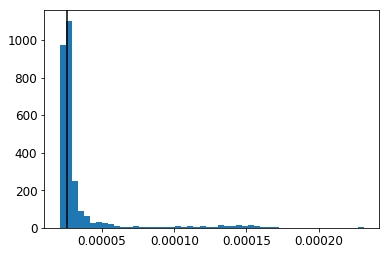

(array([682.,  41.,  20.,   4.,   3.,   5.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.5      ,  1.3740001,  2.2480001,  3.122    ,  3.996    ,
         4.87     ,  5.744    ,  6.618    ,  7.492    ,  8.366    ,
         9.24     , 10.114    , 10.988    , 11.862    , 12.736    ,
        13.610001 , 14.484    , 15.358    , 16.232    , 17.106    ,
        17.98     , 18.854    , 19.728    , 20.602001 , 21.476    ,
        22.35     , 23.224    , 24.098    , 24.972    , 25.846    ,
        26.720001 , 27.594    , 28.468    , 29.342001 , 30.216    ,
        31.09     , 31.964    , 32.838    , 33.712    , 34.586002 ,
        35.46     , 36.334    , 37.208    , 38.082    , 38.956    ,
        39.83     , 40.704002 , 41.578    , 42

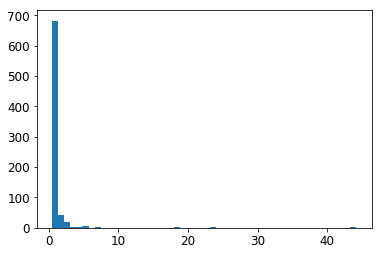

2.3
2.6
2.6
2.6
2.6
2.2
2.2
2.2
2.5
2.1
2.4


In [167]:
GLEAM_freq

[76.0,
 84.0,
 92.0,
 99.0,
 107.0,
 115.0,
 122.0,
 130.0,
 143.0,
 151.0,
 158.0,
 166.0,
 174.0,
 181.0,
 189.0,
 197.0,
 204.0,
 212.0,
 220.0,
 227.0]

In [159]:
np.ravel(np.array([9.0,5.5,1.4,0.15,GLEAM_freq]))

ValueError: setting an array element with a sequence.